In [1]:
import timeit

In [2]:
import argparse
import os
import random
from collections import namedtuple
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.utils.tensorboard import SummaryWriter
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [3]:
import QVC
import Model
import experienceReplayBuffer as erb
import Agent

In [4]:
import gym as gym

In [5]:
import pygame

In [6]:
env = gym.envs.make("CartPole-v0")

/Users/marcoemiliorodriguezserrano/anaconda3/lib/python3.10/site-packages/gym/envs/registration.py:592: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/marcoemiliorodriguezserrano/anaconda3/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/marcoemiliorodriguezserrano/anaconda3/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
# Comprobación de la versión de GYM instalada
print('La versión de gym instala: ' + gym.__version__)
# Comprobación de entorno con gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("El entorno utiliza: ", device)

La versión de gym instala: 0.25.0
El entorno utiliza:  cpu


In [8]:
#Visualizamos el entorno
for i_episode in range(15):
    observation = env.reset()
    for t in range(100):
        env.render() #EL RENDER SÓLO FUNCIONA EN LOCAL: comentar línea si no se está en local.
        print(observation)
        action = env.action_space.sample() #acción aleatoria
        observation, reward, done, info = env.step(action) #ejecución de la acción elegida
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close() #cerramos la visualización del entorno

/Users/marcoemiliorodriguezserrano/anaconda3/lib/python3.10/site-packages/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


[ 0.02348233 -0.02181925 -0.01939906 -0.03517645]
[ 0.02304595 -0.21665773 -0.02010259  0.2513233 ]
[ 0.01871279 -0.02125457 -0.01507612 -0.04763198]
[ 0.0182877  -0.21615712 -0.01602876  0.24025643]
[ 0.01396456 -0.41104648 -0.01122363  0.5278407 ]
[ 5.7436293e-03 -6.0600871e-01 -6.6681969e-04  8.1696594e-01]
[-0.00637655 -0.80112153  0.0156725   1.109439  ]
[-0.02239898 -0.60620904  0.03786128  0.8217137 ]
[-0.03452316 -0.411625    0.05429555  0.54117537]
[-0.04275566 -0.21730655  0.06511906  0.26608232]
[-0.04710179 -0.02317153  0.07044071 -0.00537155]
[-0.04756522 -0.2192293   0.07033328  0.30867824]
[-0.05194981 -0.0251763   0.07650684  0.03897933]
[-0.05245333  0.16876993  0.07728643 -0.22861792]
[-0.04907793 -0.02736653  0.07271407  0.08740812]
[-0.04962526 -0.22345138  0.07446223  0.40211725]
[-0.05409429 -0.0294602   0.08250458  0.1338085 ]
[-0.0546835  -0.22566108  0.08518074  0.45133758]
[-0.05919671 -0.03184059  0.0942075   0.18667379]
[-0.05983353 -0.22817531  0.09794097  

In [9]:
lr = 0.001            #Velocidad de aprendizaje
MEMORY_SIZE = 100000  #Máxima capacidad del buffer
MAX_EPISODES = 5000   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .99   #Decaimiento de epsilon
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal
BURN_IN = 1000        #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
DNN_UPD = 10           #Frecuencia de actualización de la red neuronal
DNN_SYNC = 30       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

In [10]:
n_layers = 5

In [11]:
buffer = erb.experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

In [12]:
n_qubits = 4
n_actions = 2
environment = 0 # Cartpole
quantum_device = "default.qubit"

In [13]:
# Networks
net = QVC.QuantumNet(n_layers, n_qubits, n_actions, environment, quantum_device)

In [14]:
target_network = QVC.QuantumNet(n_layers, n_qubits, n_actions, environment, quantum_device)

In [15]:
dqn = Model.DQN(env, net, learning_rate=lr)

In [16]:
dqn_target = Model.DQN(env, target_network, learning_rate=lr)

In [17]:
agent = Agent.DQNAgent(env, dqn, dqn_target, buffer, EPSILON, EPSILON_DECAY, BATCH_SIZE)

In [18]:
tiempo_inicio = timeit.default_timer()

In [19]:
agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES,
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...


/Users/marcoemiliorodriguezserrano/PycharmProjects/TFM_UOC/Agent.py:131: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  qvals_next[dones_t] = 0  # 0 en estados terminales


Episode 40 Mean Rewards 28.93 Epsilon 0.6757290490602831		

KeyboardInterrupt: 

In [30]:
tiempo_ejecucion = round(timeit.default_timer() - tiempo_inicio, 0)
print("Tiempo ejecución entrenamiento: " + str(int(tiempo_ejecucion/3600))
      + " horas, " + str(int((tiempo_ejecucion % 3600)/60)) + " minutos y "
      + str(int((tiempo_ejecucion % 3600)%60)) + " segundos")


Tiempo ejecución entrenamiento: 0 horas, 23 minutos y 35 segundos


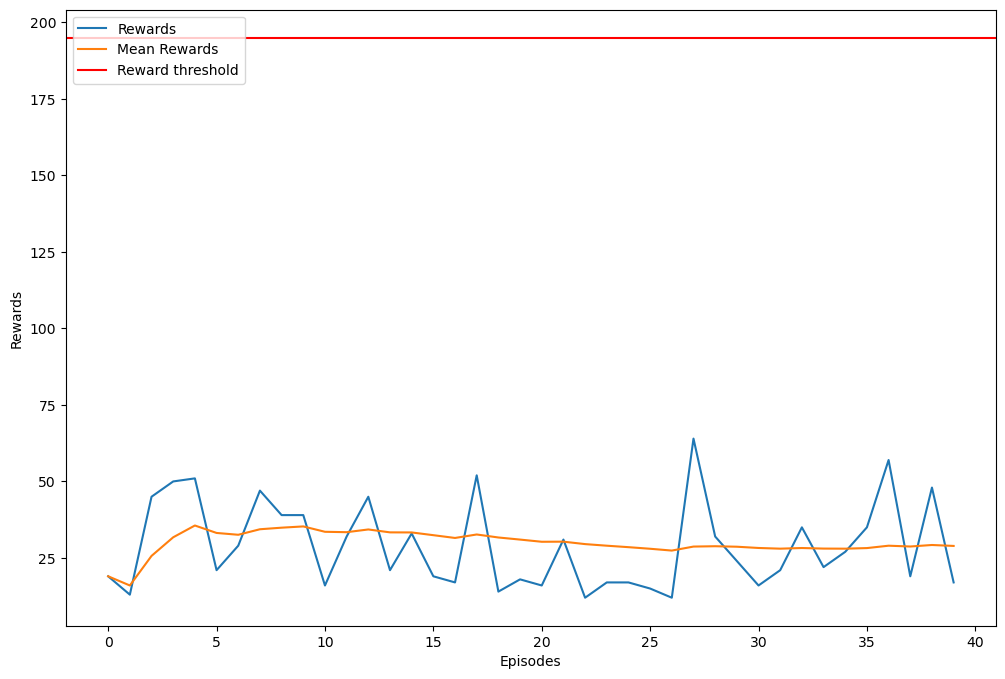

In [21]:
agent.plot_rewards()